# Импортируем нужные библиотеки

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
# from spacy import displacy
# from spacy.tokens import DocBin
# from spacy.tokens import Doc
import nltk
from gensim.parsing.preprocessing import remove_stopwords
import sklearn
from wordcloud import WordCloud

# Создаем датафрейм и просматриваем его первые строки

In [70]:
train_df = pd.read_csv('./Data/RawData/train_data.csv')
train_df = train_df.drop('Unnamed: 0', axis = 1)
train_df.head()

,publication_number,abstract,application_number,description,label
0,US-4922184-A,an apparatus for simultaneously testing multip...,US-23743888-A,"turning now to the drawings , there is shown i...",Physics
1,US-2016074097-A1,an electrosurgical instrument includes a housi...,US-201514798016-A,deployment mechanisms that are configured for ...,Human Necessities
2,US-2011188479-A1,a wireless transceiver device employing the co...,US-201113029256-A,"now , first and second embodiments of the pres...",Electricity
3,US-2013165453-A1,the invention provides for the use of protein ...,US-201213553565-A,"as used herein , “ administration ” of a compo...",Human Necessities
4,US-2008267006-A1,the present invention relates to a device for ...,US-65947604-A,"in accordance with the figures , the mixing de...",General tagging of new or cross-sectional tech...


# Классы не сбалансированны

<Axes: xlabel='count', ylabel='label'>

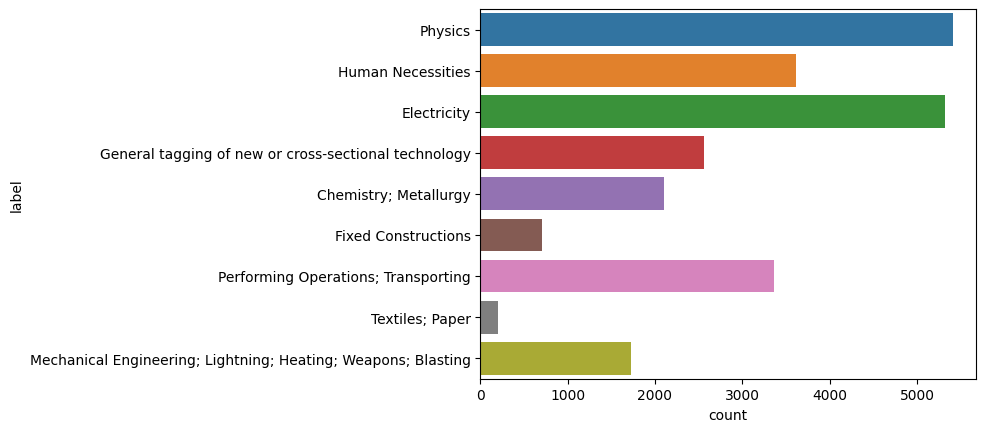

In [71]:
sns.countplot(y = train_df['label'])

# Балансировка классов

In [72]:
topics = ['Human Necessities', 'Performing Operations; Transporting', 'Chemistry; Metallurgy',
          'Physics', 'Electricity'] #'Textiles; Paper', 'Fixed Constructions' 'Mechanical Engineering; Lightning; Heating; Weapons; Blasting', 'General tagging of new or cross-sectional technology',

In [73]:
df_res = pd.DataFrame()

for topic in topics:
    df_topic = train_df[train_df['label'] == topic][:3000]
    df_res = pd.concat([df_res, df_topic], ignore_index=True)

<Axes: xlabel='count', ylabel='label'>

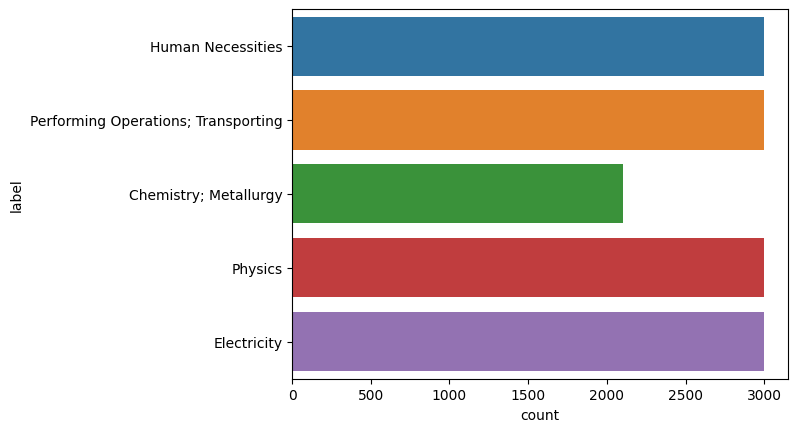

In [74]:
sns.countplot(y = df_res['label'])

# Инициализируем токенизатор из библиотеки NLTK, который токенезирует слова с помощью регулярного выражения

In [75]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer('[A-Za-z]+')

# Объявляем лемматизатор из библиотеки NLTK

In [76]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

# Создаем функцию, которая возвращает определенную часть речи, для того, чтобы лемматизатор более точно лемматизировал слово


## Загрузка необходимых файлов для работы с определением части речи

In [77]:
nltk.download('wordnet', download_dir='./.venv/Lib/site-packages/nltk/nltk_data')
nltk.download('averaged_perceptron_tagger', download_dir='./.venv/Lib/site-packages/nltk/nltk_data')
nltk.download('omw-1.4', download_dir='./.venv/Lib/site-packages/nltk/nltk_data')
nltk.download('punkt', download_dir='./.venv/Lib/site-packages/nltk/nltk_data')

nltk.data.path.append('./.venv/Lib/site-packages/nltk/nltk_data')

[nltk_data] Downloading package wordnet to ./.venv/Lib/site-
[nltk_data]     packages/nltk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     ./.venv/Lib/site-packages/nltk/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to ./.venv/Lib/site-
[nltk_data]     packages/nltk/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to ./.venv/Lib/site-
[nltk_data]     packages/nltk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Создание функции

In [78]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Создаем функцию для предпотготовки текста



In [79]:
from nltk import pos_tag

def preprocess_tokenize(row):
  lowered_row = row.lower() # Переводим в нижний регистр все слова в строке
  tokens = tokenizer.tokenize(remove_stopwords(lowered_row)) # Убираем стоп слова и токенизируем строку
  filtered_tokens = []
  for token in tokens: # Осоновываясь на части речи производим лемматизацию
    postag = get_wordnet_pos(pos_tag([token])[0][1])
    if postag == None:
      lem = lemmatizer.lemmatize(token)
      if len(lem) > 1: # Не используем слово, если его длина меньше двух символов
        filtered_tokens.append(lem)
    else:
      lem = lemmatizer.lemmatize(token, postag)
      if len(lem) > 1:
        filtered_tokens.append(lem)
  return(filtered_tokens)

# Пример преодобработки текста


In [80]:
train_df['abstract'][0]

'an apparatus for simultaneously testing multiple integrated circuits includes a sensing circuit associated with each of the tested circuits . each sensing circuit includes a differential amplifier with its positive input connected to the input of the test circuit , and its inversion input connected to the test circuit output . the test circuit input and positive amplifier input are biased to a selected voltage , and the voltage drop across the test circuit is provided to the amplifier inversion input . whenever the test circuit is open , intermittently open or highly resistive , the voltage drop across the test circuit exceeds the threshold voltage of the differential amplifier , causing the amplifier to generate a high level logic output representing an open circuit condition . the outputs of the various sensing circuits together form a digital word representative of the condition of all of the test circuits . the outputs of the differential amplifiers also are provided to independen

In [81]:
print(preprocess_tokenize(train_df['abstract'][3]))

['invention', 'provide', 'use', 'protein', 'kinase', 'activator', 'booster', 'nerve', 'growth', 'factor', 'brain', 'derive', 'neurotrophic', 'factor', 'neurotrophic', 'factor', 'treat', 'stroke', 'specifically', 'present', 'invention', 'provide', 'method', 'treat', 'stroke', 'comprise', 'step', 'identify', 'subject', 'have', 'suffer', 'stroke', 'administer', 'say', 'subject', 'pharmaceutical', 'composition', 'comprise', 'protein', 'kinase', 'activator', 'methylcatechol', 'acetic', 'acid', 'pharmaceutically', 'acceptable', 'carrier', 'effective', 'treat', 'symptom', 'stroke']


# Сходство текстов

In [86]:
nlp = spacy.load('en_core_web_md')

In [87]:
%%time

import string
punct = string.punctuation
clean_df = df_res['abstract'].apply(lambda x: nlp(x))

CPU times: total: 9min 51s
Wall time: 10min


In [88]:
def find_most_most_similar(text, df):
  index_score = {}
  for i, doc in enumerate(df):
    similarity_score = text.similarity(doc)
    index_score[i] = similarity_score
  return index_score

In [90]:
import heapq

exampleText = 'an electrosurgical instrument includes a housing , a shaft extending from the housing , and an end effector assembly attached at a distal end of the shaft . a handle assembly is coupled to the housing and includes a movable handle for manipulating the end effector assembly . an outer sleeve is disposed about the shaft and selectively translatable relative thereto . an energizable member is operably coupled to the outer sleeve . a deployment mechanism is provided including a lever rotatably coupled to the housing and positioned proximally of the movable handle and at least one link member coupled between the lever and the outer sleeve . the link member couple to the outer sleeve distally of the movable handle . rotation of the lever translates the outer sleeve distally to move the outer sleeve over the end effector assembly and simultaneously deploy the energizable member distally past the end effector assembly'
result = find_most_most_similar(nlp(exampleText), clean_df)
most_similar_texts = heapq.nlargest(5, result, key=result.get)
for i in most_similar_texts:
  print(df_res['abstract'][i])
  print(result[i])
  print()

an electrosurgical instrument includes a housing , a shaft extending from the housing , and an end effector assembly attached at a distal end of the shaft . a handle assembly is coupled to the housing and includes a movable handle for manipulating the end effector assembly . an outer sleeve is disposed about the shaft and selectively translatable relative thereto . an energizable member is operably coupled to the outer sleeve . a deployment mechanism is provided including a lever rotatably coupled to the housing and positioned proximally of the movable handle and at least one link member coupled between the lever and the outer sleeve . the link member couple to the outer sleeve distally of the movable handle . rotation of the lever translates the outer sleeve distally to move the outer sleeve over the end effector assembly and simultaneously deploy the energizable member distally past the end effector assembly .
0.9999547610832082

an assembly including a pump attachment particularly a

# Векторизируем текст с помощью частотной модели TF-IDF

In [43]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, lowercase = False, tokenizer = preprocess_tokenize,
                             max_df = 0.2, ngram_range = (1, 3), max_features=10000)

tfidf_matrix = tfidf_vectorizer.fit_transform(df_res['abstract'])

wordlist = tfidf_vectorizer.get_feature_names_out()
tfidf_2d_array = tfidf_matrix.toarray()

CPU times: total: 7min 8s
Wall time: 7min 12s


# Оценка работы частотной модели TF-IDF

In [39]:
def avg_tfidf_weight(tfidf_2d_array, wordlist):

  tfidf_nans = np.where(tfidf_2d_array == 0.0, np.nan, tfidf_2d_array) #Заменяем все нули на NaN
  avg_word_weight = np.nanmean(tfidf_nans, axis = 0) #Берем среднее по каждому столбцу, исключая NaN
  avg_word_weight[np.isnan(avg_word_weight)] = 0.0
  dict_word_weight = dict(zip(wordlist, avg_word_weight)) #Создаем словарь "слово: вес"

  return dict_word_weight

In [44]:
# def avg_tfidf_weight1(tfidf_2d_array, wordlist):

#   row_len = len(tfidf_2d_array[0])
#   sum_of_tfidfs, word_accurance = [0.0] * row_len, [0] * row_len

#   for row in range(len(tfidf_2d_array)):
#     for element in range(row_len):
#       if tfidf_2d_array[row][element] != 0.0:
#         word_accurance[element] += 1
#         sum_of_tfidfs[element] += tfidf_2d_array[row][element]

#   avg_word_tfidf = []
#   for x, y in zip(sum_of_tfidfs, word_accurance):
#       if y != 0:
#         avg_word_tfidf.append(x/y)
#       else:
#         avg_word_tfidf.append(0.0)

#   avg_tfidf_word_dict = dict(zip(wordlist, avg_word_tfidf))

#   return avg_tfidf_word_dict

In [45]:
%%time
total_avg_tfidf = avg_tfidf_weight(tfidf_2d_array, wordlist)
#total_avg_tfidf1 = avg_tfidf_weight1(tfidf_2d_array)

CPU times: total: 1.36 s
Wall time: 1.42 s


## Средняя важность слова во всем корпусе текстов

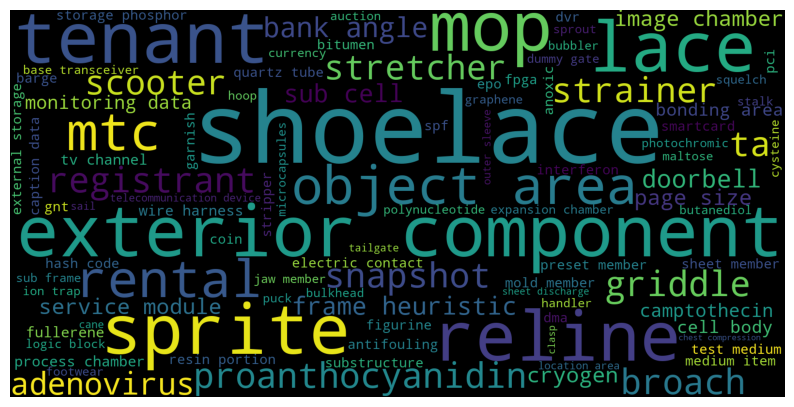

In [51]:
wordcloud = WordCloud(width=1600, height=800, max_words = 100).fit_words(total_avg_tfidf)
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(wordcloud)
#plt.savefig('wordcloud.png', facecolor='k', bbox_inches='tight')

## Топ 5 важных слов в каждом классе

In [54]:
%%time
for topic in topics:
  tfidf_2darray_class = []
  for vector, label in zip(tfidf_2d_array, df_res['label'].tolist()):
    if label == topic:
      tfidf_2darray_class.append(vector)

  # avg_tfidf_word_dict_class = avg_tfidf_weight(tfidf_2darray_class, wordlist)
  # print(avg_tfidf_word_dict_class)
  # avg_tfidf_word_dict_class1 = avg_tfidf_weight1(tfidf_2darray_class)
  # print(avg_tfidf_word_dict_class1)

  # shared_items = {k: avg_tfidf_word_dict_class[k] for k in avg_tfidf_word_dict_class if avg_tfidf_word_dict_class[k] == avg_tfidf_word_dict_class1[k]}
  # print(len(shared_items))

  top_words = heapq.nlargest(5, avg_tfidf_word_dict_class, key=avg_tfidf_word_dict_class.get)

  print(topic + ':', end= ' ')
  print(*top_words, sep=', ')

Human Necessities: body, member, patient, portion, end
Performing Operations; Transporting: body, member, patient, portion, end
Chemistry; Metallurgy: body, member, patient, portion, end
Physics: body, member, patient, portion, end
Electricity: body, member, patient, portion, end
CPU times: total: 31.2 ms
Wall time: 25 ms


# Разделяем данные на обучение и тест

In [56]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(tfidf_matrix, df_res['label'], train_size=0.7, random_state = 42)

# Классифицируем текст с помощью метода опорных векторов

In [57]:
from sklearn import svm

SVM = svm.LinearSVC(penalty='l2', loss='squared_hinge', dual=True, C=0.1, fit_intercept=False, intercept_scaling=0.01, class_weight='balanced', random_state=42, max_iter=10000)
SVM.fit(x_train,y_train)
svm_predictions = SVM.predict(x_test)

In [58]:
from sklearn.metrics import classification_report

print(classification_report(svm_predictions, y_test, target_names=topics))

                                     precision    recall  f1-score   support

                  Human Necessities       0.85      0.71      0.77       739
Performing Operations; Transporting       0.70      0.71      0.71       854
              Chemistry; Metallurgy       0.63      0.77      0.69       747
                            Physics       0.74      0.68      0.71      1002
                        Electricity       0.63      0.65      0.64       888

                           accuracy                           0.70      4230
                          macro avg       0.71      0.70      0.70      4230
                       weighted avg       0.71      0.70      0.70      4230



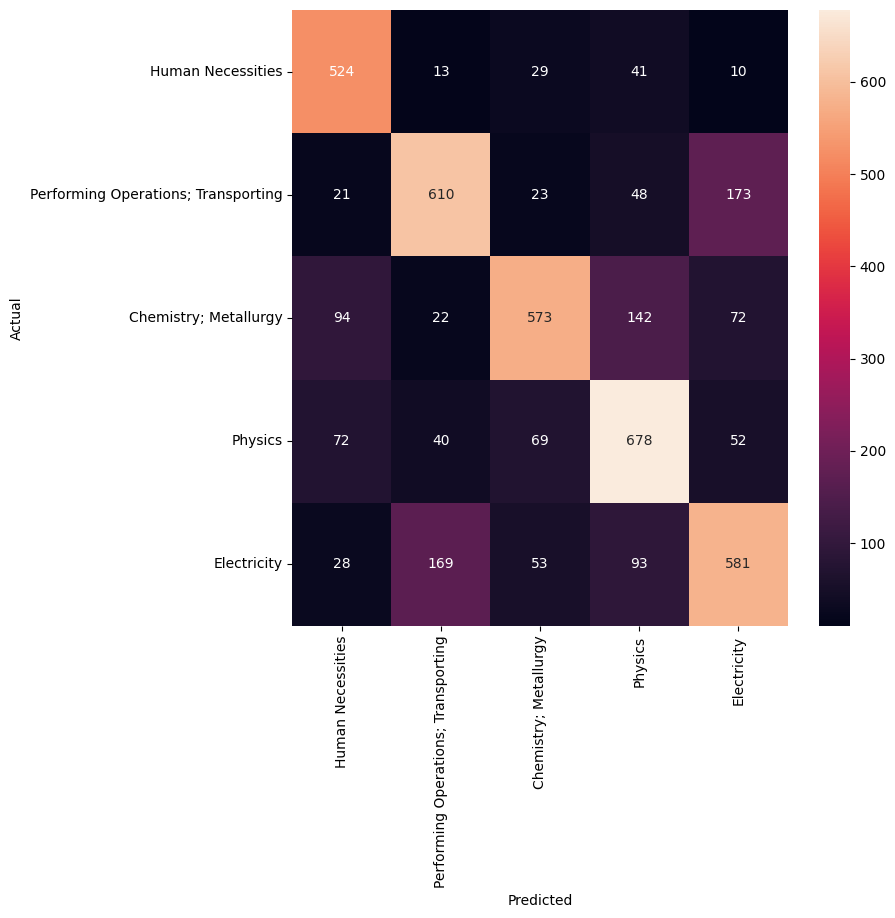

In [59]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, svm_predictions)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=topics, yticklabels=topics)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Классифицируем текст с помощью метода k ближайших соседей

In [60]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors=35, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', n_jobs=-1)
KNN.fit(x_train,y_train)
knn_predictions = KNN.predict(x_test)

In [61]:
print(classification_report(knn_predictions, y_test, target_names=topics))

                                     precision    recall  f1-score   support

                  Human Necessities       0.85      0.70      0.77       742
Performing Operations; Transporting       0.73      0.67      0.70       961
              Chemistry; Metallurgy       0.57      0.74      0.65       695
                            Physics       0.75      0.64      0.69      1068
                        Electricity       0.56      0.68      0.62       764

                           accuracy                           0.68      4230
                          macro avg       0.69      0.69      0.68      4230
                       weighted avg       0.70      0.68      0.68      4230



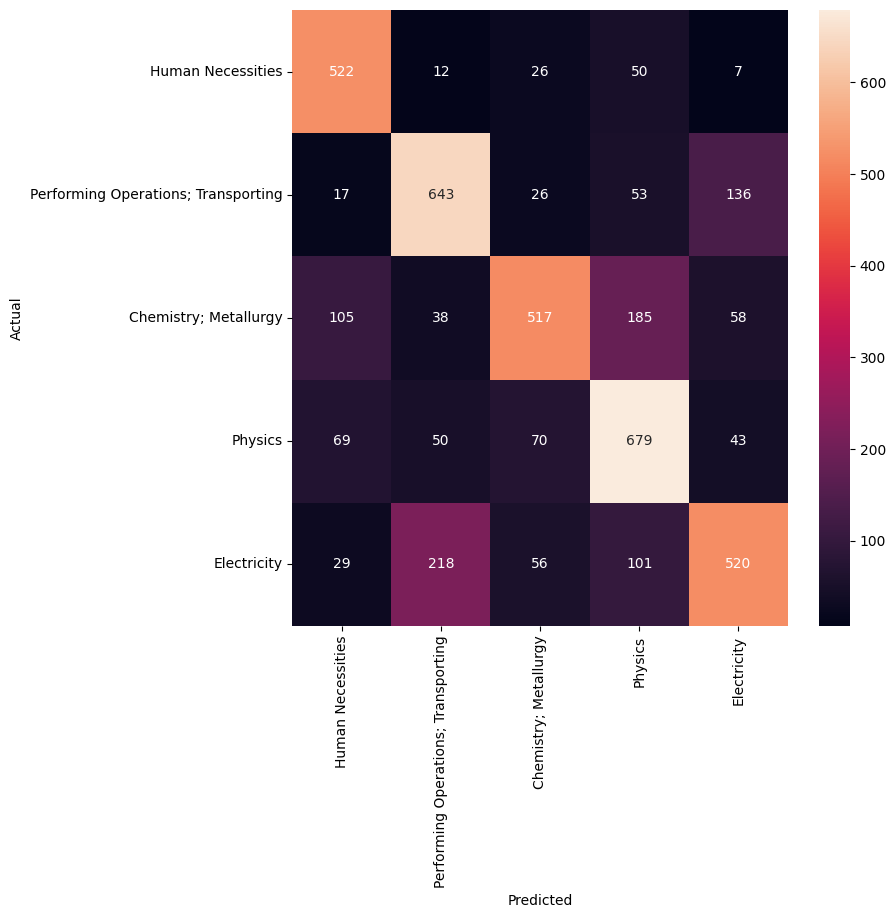

In [62]:
conf_mat = confusion_matrix(y_test, knn_predictions)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=topics, yticklabels=topics)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Классифицируем текст с помощью наивного Байесовского классификатора

In [66]:
from sklearn import naive_bayes

Naive = naive_bayes.ComplementNB(alpha=0.1, force_alpha=True, fit_prior=True, norm=False)
Naive.fit(x_train,y_train)
naive_predictions = Naive.predict(x_test)

In [67]:
print(classification_report(naive_predictions, y_test, target_names=topics))

                                     precision    recall  f1-score   support

                  Human Necessities       0.89      0.66      0.76       828
Performing Operations; Transporting       0.65      0.71      0.68       800
              Chemistry; Metallurgy       0.56      0.81      0.67       624
                            Physics       0.76      0.62      0.69      1110
                        Electricity       0.60      0.64      0.62       868

                           accuracy                           0.68      4230
                          macro avg       0.69      0.69      0.68      4230
                       weighted avg       0.70      0.68      0.68      4230



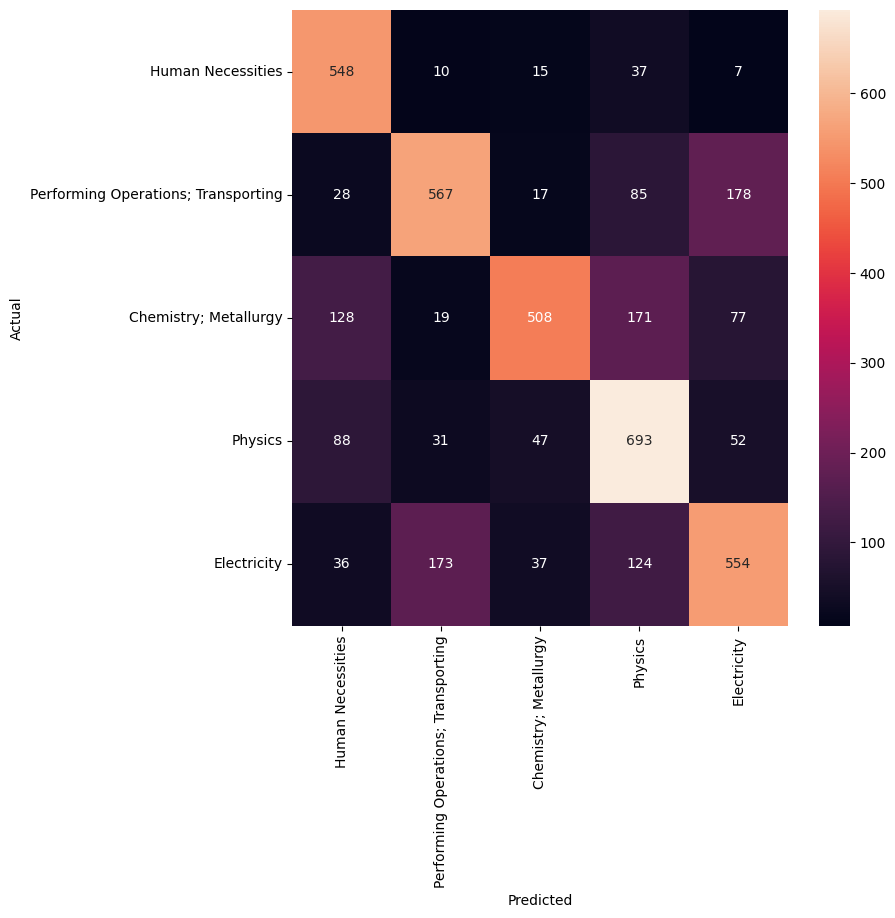

In [68]:
conf_mat = confusion_matrix(y_test, naive_predictions)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=topics, yticklabels=topics)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()